In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline  import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization

## Import Data

In [2]:
#read the dataframe in & observe
df = pd.read_csv('./googleplaystore.csv')
df.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Ratings have some missing data so we'll remove those rows. Installs, price & reviews should be int. Last Updated should be date

## Clean Data

In [4]:
df.dropna(inplace=True)
df.shape #(9360,13)
df.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [5]:
#converting installs to integers
df['Installs']=df['Installs'].str.replace('+','').str.replace(',','')
df['Installs'] = df['Installs'].astype(int)

#change price to float
df['Price']=df['Price'].str.replace('$','').astype(float)
#convert reviews to int
df['Reviews'] = df['Reviews'].astype(int)

#convert dates to date time
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

#convert rating content to string
df['Content Rating'] = df['Content Rating'].astype(str)

df['Size'] = df['Size'].str.replace('M','').str.replace('k','').str.replace('Varies with device','308')
df['Size'] = df['Size'].astype(float)

#obsever
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             9360 non-null   object        
 1   Category        9360 non-null   object        
 2   Rating          9360 non-null   float64       
 3   Reviews         9360 non-null   int64         
 4   Size            9360 non-null   float64       
 5   Installs        9360 non-null   int64         
 6   Type            9360 non-null   object        
 7   Price           9360 non-null   float64       
 8   Content Rating  9360 non-null   object        
 9   Genres          9360 non-null   object        
 10  Last Updated    9360 non-null   datetime64[ns]
 11  Current Ver     9360 non-null   object        
 12  Android Ver     9360 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 1023.8+ KB


<ipython-input-5-83431fa92256>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Installs']=df['Installs'].str.replace('+','').str.replace(',','')
<ipython-input-5-83431fa92256>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Price']=df['Price'].str.replace('$','').astype(float)


## EDA

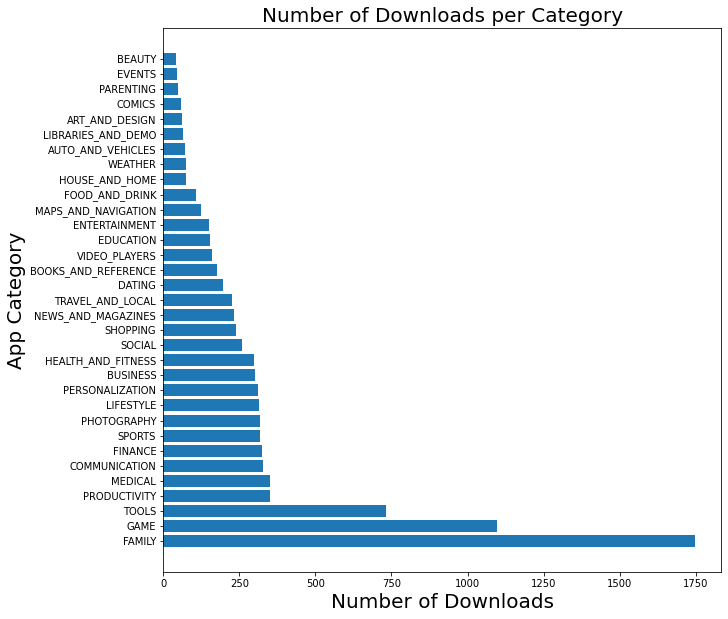

In [6]:
plt.figure(figsize=(10,10))
plt.barh(df['Category'].value_counts().index,df['Category'].value_counts());
plt.ylabel('App Category', size = 20)
plt.xlabel('Number of Downloads', size =20)
plt.title('Number of Downloads per Category',size = 20);

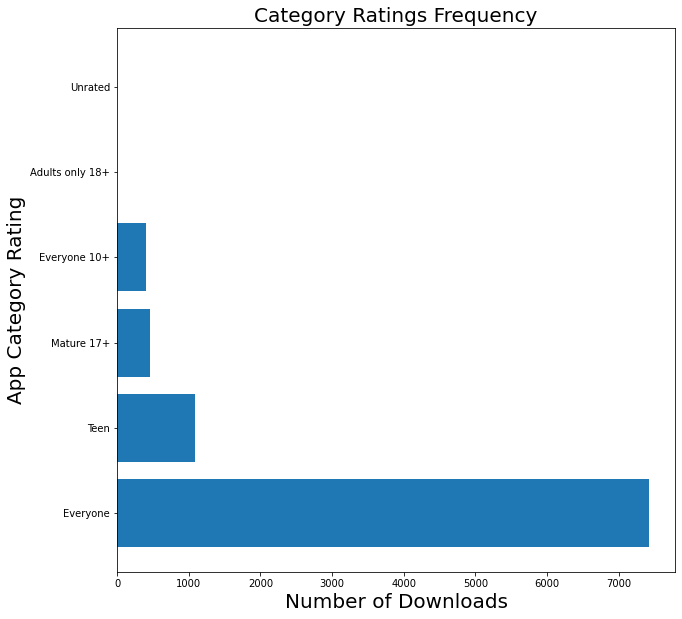

In [7]:
plt.figure(figsize=(10,10))
plt.barh(df['Content Rating'].value_counts().index,df['Content Rating'].value_counts());
plt.ylabel('App Category Rating', size = 20)
plt.xlabel('Number of Downloads', size =20)
plt.title('Category Ratings Frequency',size = 20);

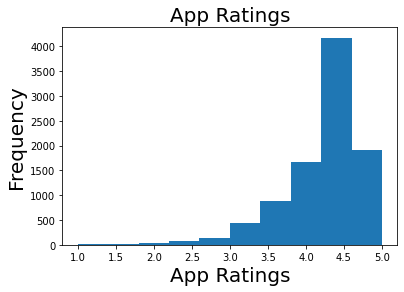

In [8]:
plt.hist(df['Rating']);
plt.ylabel('Frequency', size = 20)
plt.xlabel('App Ratings', size =20)
plt.title('App Ratings',size = 20);

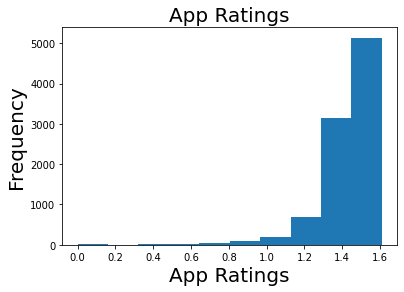

In [32]:
plt.hist(np.log(df['Rating']));
plt.ylabel('Frequency', size = 20)
plt.xlabel('App Ratings', size =20)
plt.title('App Ratings',size = 20);

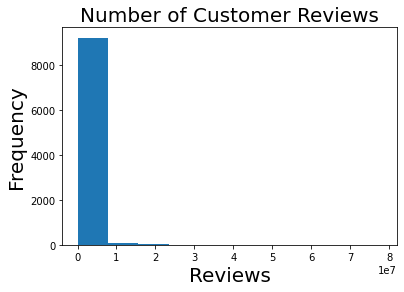

In [9]:
plt.hist(df['Reviews']);
plt.ylabel('Frequency', size = 20)
plt.xlabel('Reviews', size =20)
plt.title('Number of Customer Reviews',size = 20);

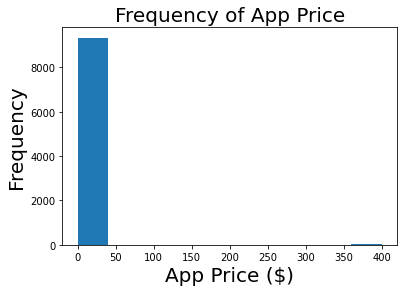

In [10]:
plt.hist(df['Price']);
plt.ylabel('Frequency', size = 20)
plt.xlabel('App Price ($)', size =20)
plt.title('Frequency of App Price',size = 20);

In [11]:
df.loc[ (df['Rating'] == 5.0)]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
329,Hojiboy Tojiboyev Life Hacks,COMICS,5.0,15,37.0,1000,Free,0.0,Everyone,Comics,2018-06-26,2.0,4.0.3 and up
612,American Girls Mobile Numbers,DATING,5.0,5,4.4,1000,Free,0.0,Mature 17+,Dating,2018-07-17,3.0,4.0.3 and up
615,Awake Dating,DATING,5.0,2,70.0,100,Free,0.0,Mature 17+,Dating,2018-07-24,2.2.9,4.4 and up
633,Spine- The dating app,DATING,5.0,5,9.3,500,Free,0.0,Teen,Dating,2018-07-14,4.0,4.0.3 and up
636,Girls Live Talk - Free Text and Video Chat,DATING,5.0,6,5.0,100,Free,0.0,Mature 17+,Dating,2018-08-01,8.2,4.0.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10721,Mad Dash Fo' Cash,GAME,5.0,14,16.0,100,Free,0.0,Everyone,Arcade,2017-06-19,2.5a,4.1 and up
10742,GKPB FP Online Church,LIFESTYLE,5.0,32,7.9,1000,Free,0.0,Everyone,Lifestyle,2017-12-31,0.7.1,4.4 and up
10776,Monster Ride Pro,GAME,5.0,1,24.0,10,Free,0.0,Everyone,Racing,2018-03-05,2.0,2.3 and up
10820,Fr. Daoud Lamei,FAMILY,5.0,22,8.6,1000,Free,0.0,Teen,Education,2018-06-27,3.8.0,4.1 and up


In [12]:
df['Price'].max()

400.0

In [13]:
df.loc[(df['Price'] == 400.0)]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.3,10000,Paid,400.0,Everyone,Lifestyle,2018-05-03,1.0.1,4.1 and up


In [14]:
df['Rating'].max()

5.0

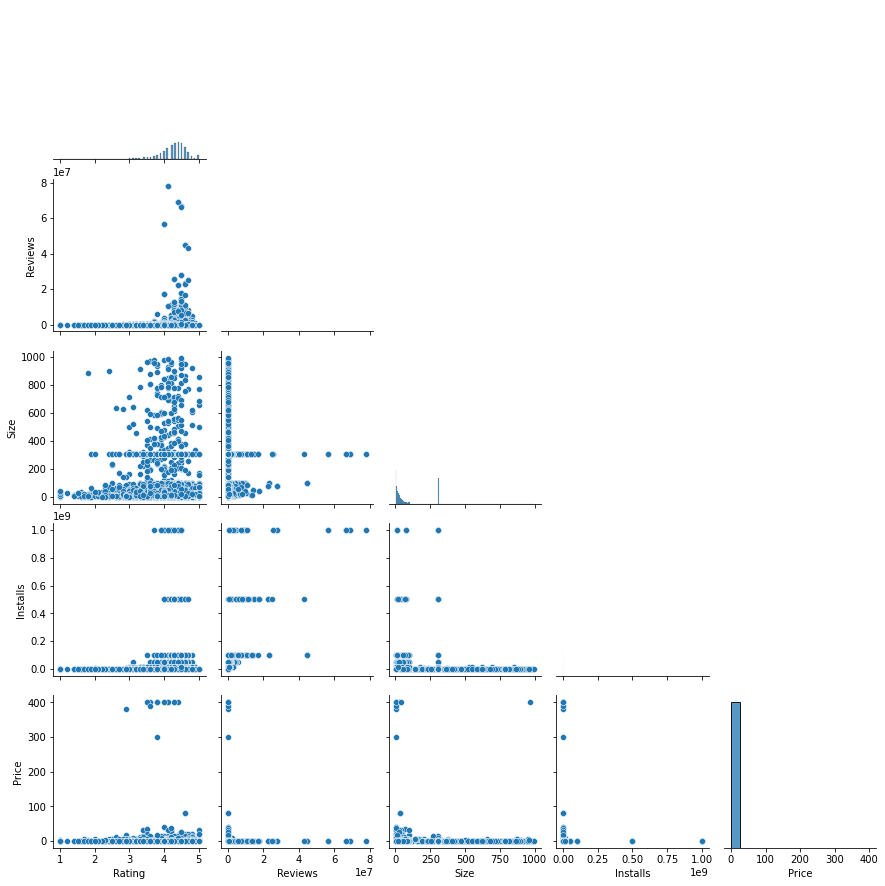

In [15]:
sns.pairplot(df, corner=True)

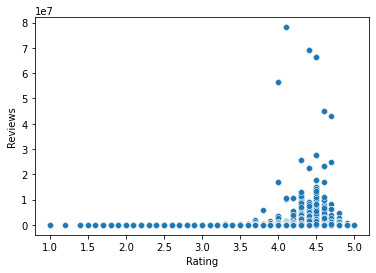

In [16]:
sns.scatterplot(data = df, x='Rating', y='Reviews');#, hue='Rating');

<AxesSubplot:>

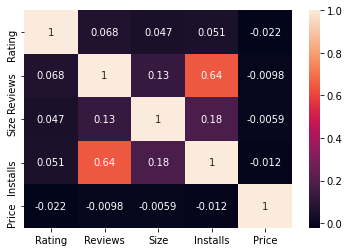

In [17]:
sns.heatmap(df.corr(), annot = True)

### Baseline accuracy

In [18]:
y = df['Rating']
mean_squared_error(y,np.full_like(y,np.mean(y)))

0.2654675633720505

### Choose X & Y

In [19]:
df.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up


### Basic Linear Regression

In [20]:
X = df[['Reviews','Installs','Size']]
y = df['Rating']

X_train, X_test, y_train ,y_test = train_test_split(X,y, random_state=518)

#Create pipe
pipe_lr = make_pipeline(StandardScaler(),
                       LinearRegression())
#fit model
pipe_lr.fit(X_train,y_train)


#score on train 
pipe_lr.score(X_train,y_train) #0.0061

#score on test 
#pipe_lr.score(X_test,y_test) #0.0059

0.006135939693755588

In [21]:
preds_lr = pipe_lr.predict(X_test)
mean_squared_error(y_test,preds_lr)

0.26535013881943975

In [26]:
#

### Linear Regression with OHE & Pipe

In [22]:
X = df[['Category','Reviews','Installs','Size']]
y = df['Rating']

X_train, X_test, y_train ,y_test = train_test_split(X,y, random_state=518)

#transform column with OHE
trans_col = make_column_transformer((OneHotEncoder(use_cat_names=True), make_column_selector('Category')) )

#create pipe
pipe_lr = make_pipeline(trans_col,
                        StandardScaler(),
                       LinearRegression())
#fit model
pipe_lr.fit(X_train,y_train)

#score on train 
pipe_lr.score(X_train,y_train) #0.034

#score on test 
pipe_lr.score(X_test,y_test) #0.016

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.016484544108855914

In [23]:
preds_lr = pipe_lr.predict(X_test)
mean_squared_error(y_test,preds_lr)

0.2625488366571211

In [28]:
#

### Elastic Net with OHE & Grid Search

In [24]:
X = df[['Category','Reviews','Installs','Size']]
y = df['Rating']

X_train, X_test, y_train ,y_test = train_test_split(X,y, random_state=518)

#transform column with OHE
trans_col = make_column_transformer((OneHotEncoder(use_cat_names=True), make_column_selector('Category')) )

#create pipe
pipe_elastic = make_pipeline(trans_col,
                        StandardScaler(),
                       ElasticNet())
params_elastic = {'elasticnet__alpha':[0.01, 0.1, 1, 10, 100,1000],
                  'elasticnet__l1_ratio':[0.2,0.4,0.6,0.8]}

gs_elastic = GridSearchCV(pipe_elastic, params_elastic, n_jobs=-1)


gs_elastic.fit(X_train, y_train)

gs_elastic.best_params_ # alpha 0.01, l1ratio 0.2

gs_elastic.score(X_train,y_train) #0.0338

gs_elastic.score(X_test,y_test) # 0.0174

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.017448494062848208

In [26]:
preds_elastic = gs_elastic.predict(X_test)
mean_squared_error(y_test,preds_elastic)

0.26229151081897545

In [ ]:
#

### KNN with GridSearch

In [27]:
X = df[['Category','Reviews','Installs','Price','Size']]
y = df['Rating']

X_train, X_test, y_train ,y_test = train_test_split(X,y, random_state=518)

#transform column with OHE
trans_col = make_column_transformer((OneHotEncoder(use_cat_names=True), make_column_selector('Category')) )

#create pipe
pipe_knn = make_pipeline(trans_col,
                        StandardScaler(),
                       KNeighborsRegressor())

params_knn = {'kneighborsregressor__n_neighbors':[10,50,200,300,400,500],
             'kneighborsregressor__leaf_size':[10,30,60,100]}

gs_knn = GridSearchCV(pipe_knn, params_knn, n_jobs=-1)

gs_knn.fit(X_train,y_train)

gs_knn.best_params_ #leaf_size 10, n_neighbors 200

gs_knn.score(X_train,y_train) #0.0306

gs_knn.score(X_test,y_test) #0.0203

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.02030244609388443

In [28]:
preds_knn = gs_knn.predict(X_test)
mean_squared_error(y_test,preds_knn)

0.26152965010683765

In [ ]:
#

### Random Forest

In [29]:
X = df[['Category','Reviews','Installs','Price','Size']]
y = df['Rating']

X_train, X_test, y_train ,y_test = train_test_split(X,y, random_state=518)

#transform column with OHE
trans_col = make_column_transformer((OneHotEncoder(use_cat_names=True), make_column_selector('Category')) )

#create pipe
pipe_rf = make_pipeline(trans_col,
                        StandardScaler(),
                       RandomForestRegressor())

params_rf = {'randomforestregressor__n_estimators':[100,200,300,400,500],
             'randomforestregressor__max_depth':[100,500,1000]}

gs_rf = GridSearchCV(pipe_rf, params_rf, n_jobs = -1)

gs_rf.fit(X_train,y_train)

gs_rf.best_params_ #max_depth 500, n_estimators 100

gs_rf.score(X_train,y_train) #0.034

gs_rf.score(X_test,y_test) #0.0168

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.0162898115249559

In [30]:
preds_rf = gs_rf.predict(X_test)
mean_squared_error(y_test,preds_rf)

0.26260082039876537

### Import new text data (Reviews of apps)

In [31]:
reviews = pd.read_csv('./googleplaystore_user_reviews.csv')

In [32]:

#observe & merge with existing df
reviews.shape #(64295, 5)

df.shape #(9360, 13)

reviews.drop_duplicates(inplace=True)
reviews.shape #(30679, 5)

merged_df = pd.merge(left = reviews, right = df, on='App').dropna()


merged_df.shape #(46691, 17)
merged_df.isna().sum() # all 0
merged_df.head(3)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Everyone 10+,Health & Fitness,2017-02-17,1.9,2.3.3 and up
1,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Everyone 10+,Health & Fitness,2017-02-17,1.9,2.3.3 and up
2,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,HEALTH_AND_FITNESS,4.0,2490,3.8,500000,Free,0.0,Everyone 10+,Health & Fitness,2017-02-17,1.9,2.3.3 and up


#### Label encdode

In [33]:
le = LabelEncoder()
merged_df['Sentiment'] = le.fit_transform(merged_df['Sentiment'])

merged_df['Sentiment'].unique() #array([2, 1, 0])

array([2, 1, 0])

<AxesSubplot:>

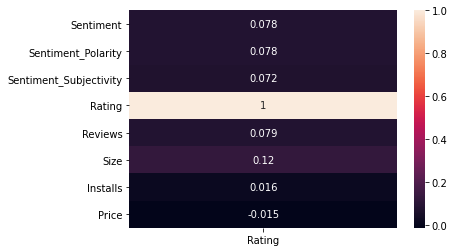

In [34]:
sns.heatmap(merged_df.corr()[['Rating']], annot = True)

### Predict on best performing model

In [35]:
X = merged_df[['Category','Sentiment_Polarity','Sentiment_Subjectivity','Sentiment','Installs','Price','Size']]
y = merged_df['Rating']

X_train, X_test, y_train ,y_test = train_test_split(X,y, random_state=518)


#transform column with OHE
trans_col = make_column_transformer((OneHotEncoder(use_cat_names=True), make_column_selector('Category')) )

#create pipe
pipe_knn = make_pipeline(trans_col,
                        StandardScaler(),
                       KNeighborsRegressor())

params_knn = {'kneighborsregressor__n_neighbors':[200],
             'kneighborsregressor__leaf_size':[10]}

gs_knn = GridSearchCV(pipe_knn, params_knn, n_jobs=-1)

gs_knn.fit(X_train,y_train)

gs_knn.best_params_ #leaf_size 10, n_neighbors 200

gs_knn.score(X_train,y_train) #0.15

gs_knn.score(X_test,y_test) #0.15

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.1509456301791129

In [31]:
preds_knn = gs_knn.predict(X_test)
mean_squared_error(y_test,preds_knn)

0.26152965010683765

In [ ]:
#next poly features, neural nets

In [253]:
model = Sequential()
model.add(Input(shape=20,))
model.add(Dense(12,activation= 'relu'))
model.add(Dense(1))

In [254]:
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [256]:
history = model.fit(
    X_train_sc,
    y_train,
    batch_size = 128,
    validation_data=(X_test_sc,y_test),
    epochs = 100)

Epoch 1/100


ValueError: in user code:

    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 20 but received input with shape (None, 33)


In [ ]:
preds = model.predict(X_test)
preds

In [ ]:
model.evaluate(X_test,y_test)